In [1]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached catboost-1.2.7-cp39-cp39-win_amd64.whl (101.8 MB)
  Using cached plotly-6.0.0-py3-none-any.whl (14.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     --------------------------------------- 11.2/11.2 MB 13.3 MB/s eta 0:00:00
     ------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# for data manipulation
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for data splitting, transforming and model training
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Import Warnings
import warnings
warnings.simplefilter(action="ignore")

In [9]:
# Setting Configurations:

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [10]:
df = pd.read_csv(r'\Users\jayr\Downloads\Telco-Customer-Churn-Expanded.csv')

In [11]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [12]:
df.shape

(500000, 21)

In [14]:
def check_data(dataframe, head=5):

    print(20*"-" + "Information".center(20) + 20*"-")
    print(dataframe.info())
    print(20*"-" + "Data Shape".center(20) + 20*"-")
    print(dataframe.shape)
    print("\n" + 20*"-" + "The First 5 Data".center(20) + 20*"-")
    print(dataframe.head())
    print("\n" + 20 * "-" + "The Last 5 Data".center(20) + 20 * "-")
    print(dataframe.tail())
    print("\n" + 20 * "-" + "Missing Values".center(20) + 20 * "-")
    print(dataframe.isnull().sum())
    print("\n" + 40 * "-" + "Describe the Data".center(40) + 40 * "-")
    print(dataframe.describe([0.01, 0.05, 0.10, 0.50, 0.75, 0.90, 0.95, 0.99]).T)


check_data(df)

--------------------    Information     --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customerID        500000 non-null  object 
 1   gender            500000 non-null  object 
 2   SeniorCitizen     500000 non-null  int64  
 3   Partner           500000 non-null  object 
 4   Dependents        500000 non-null  object 
 5   tenure            500000 non-null  int64  
 6   PhoneService      500000 non-null  object 
 7   MultipleLines     500000 non-null  object 
 8   InternetService   500000 non-null  object 
 9   OnlineSecurity    500000 non-null  object 
 10  OnlineBackup      500000 non-null  object 
 11  DeviceProtection  500000 non-null  object 
 12  TechSupport       500000 non-null  object 
 13  StreamingTV       500000 non-null  object 
 14  StreamingMovies   500000 non-null  object 
 15  Contrac

In [15]:
pd.to_numeric(df.TotalCharges, errors='coerce').isna()
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce') 
# Using errors=coerce. It will replace all non-numeric values with NaN.

In [17]:
# To find the number of churners and non-churners in the dataset:
df["Churn"].value_counts()

No     367568
Yes    132432
Name: Churn, dtype: int64

In [18]:
df["Churn"] = df["Churn"].map({'No': 0, 'Yes': 1})

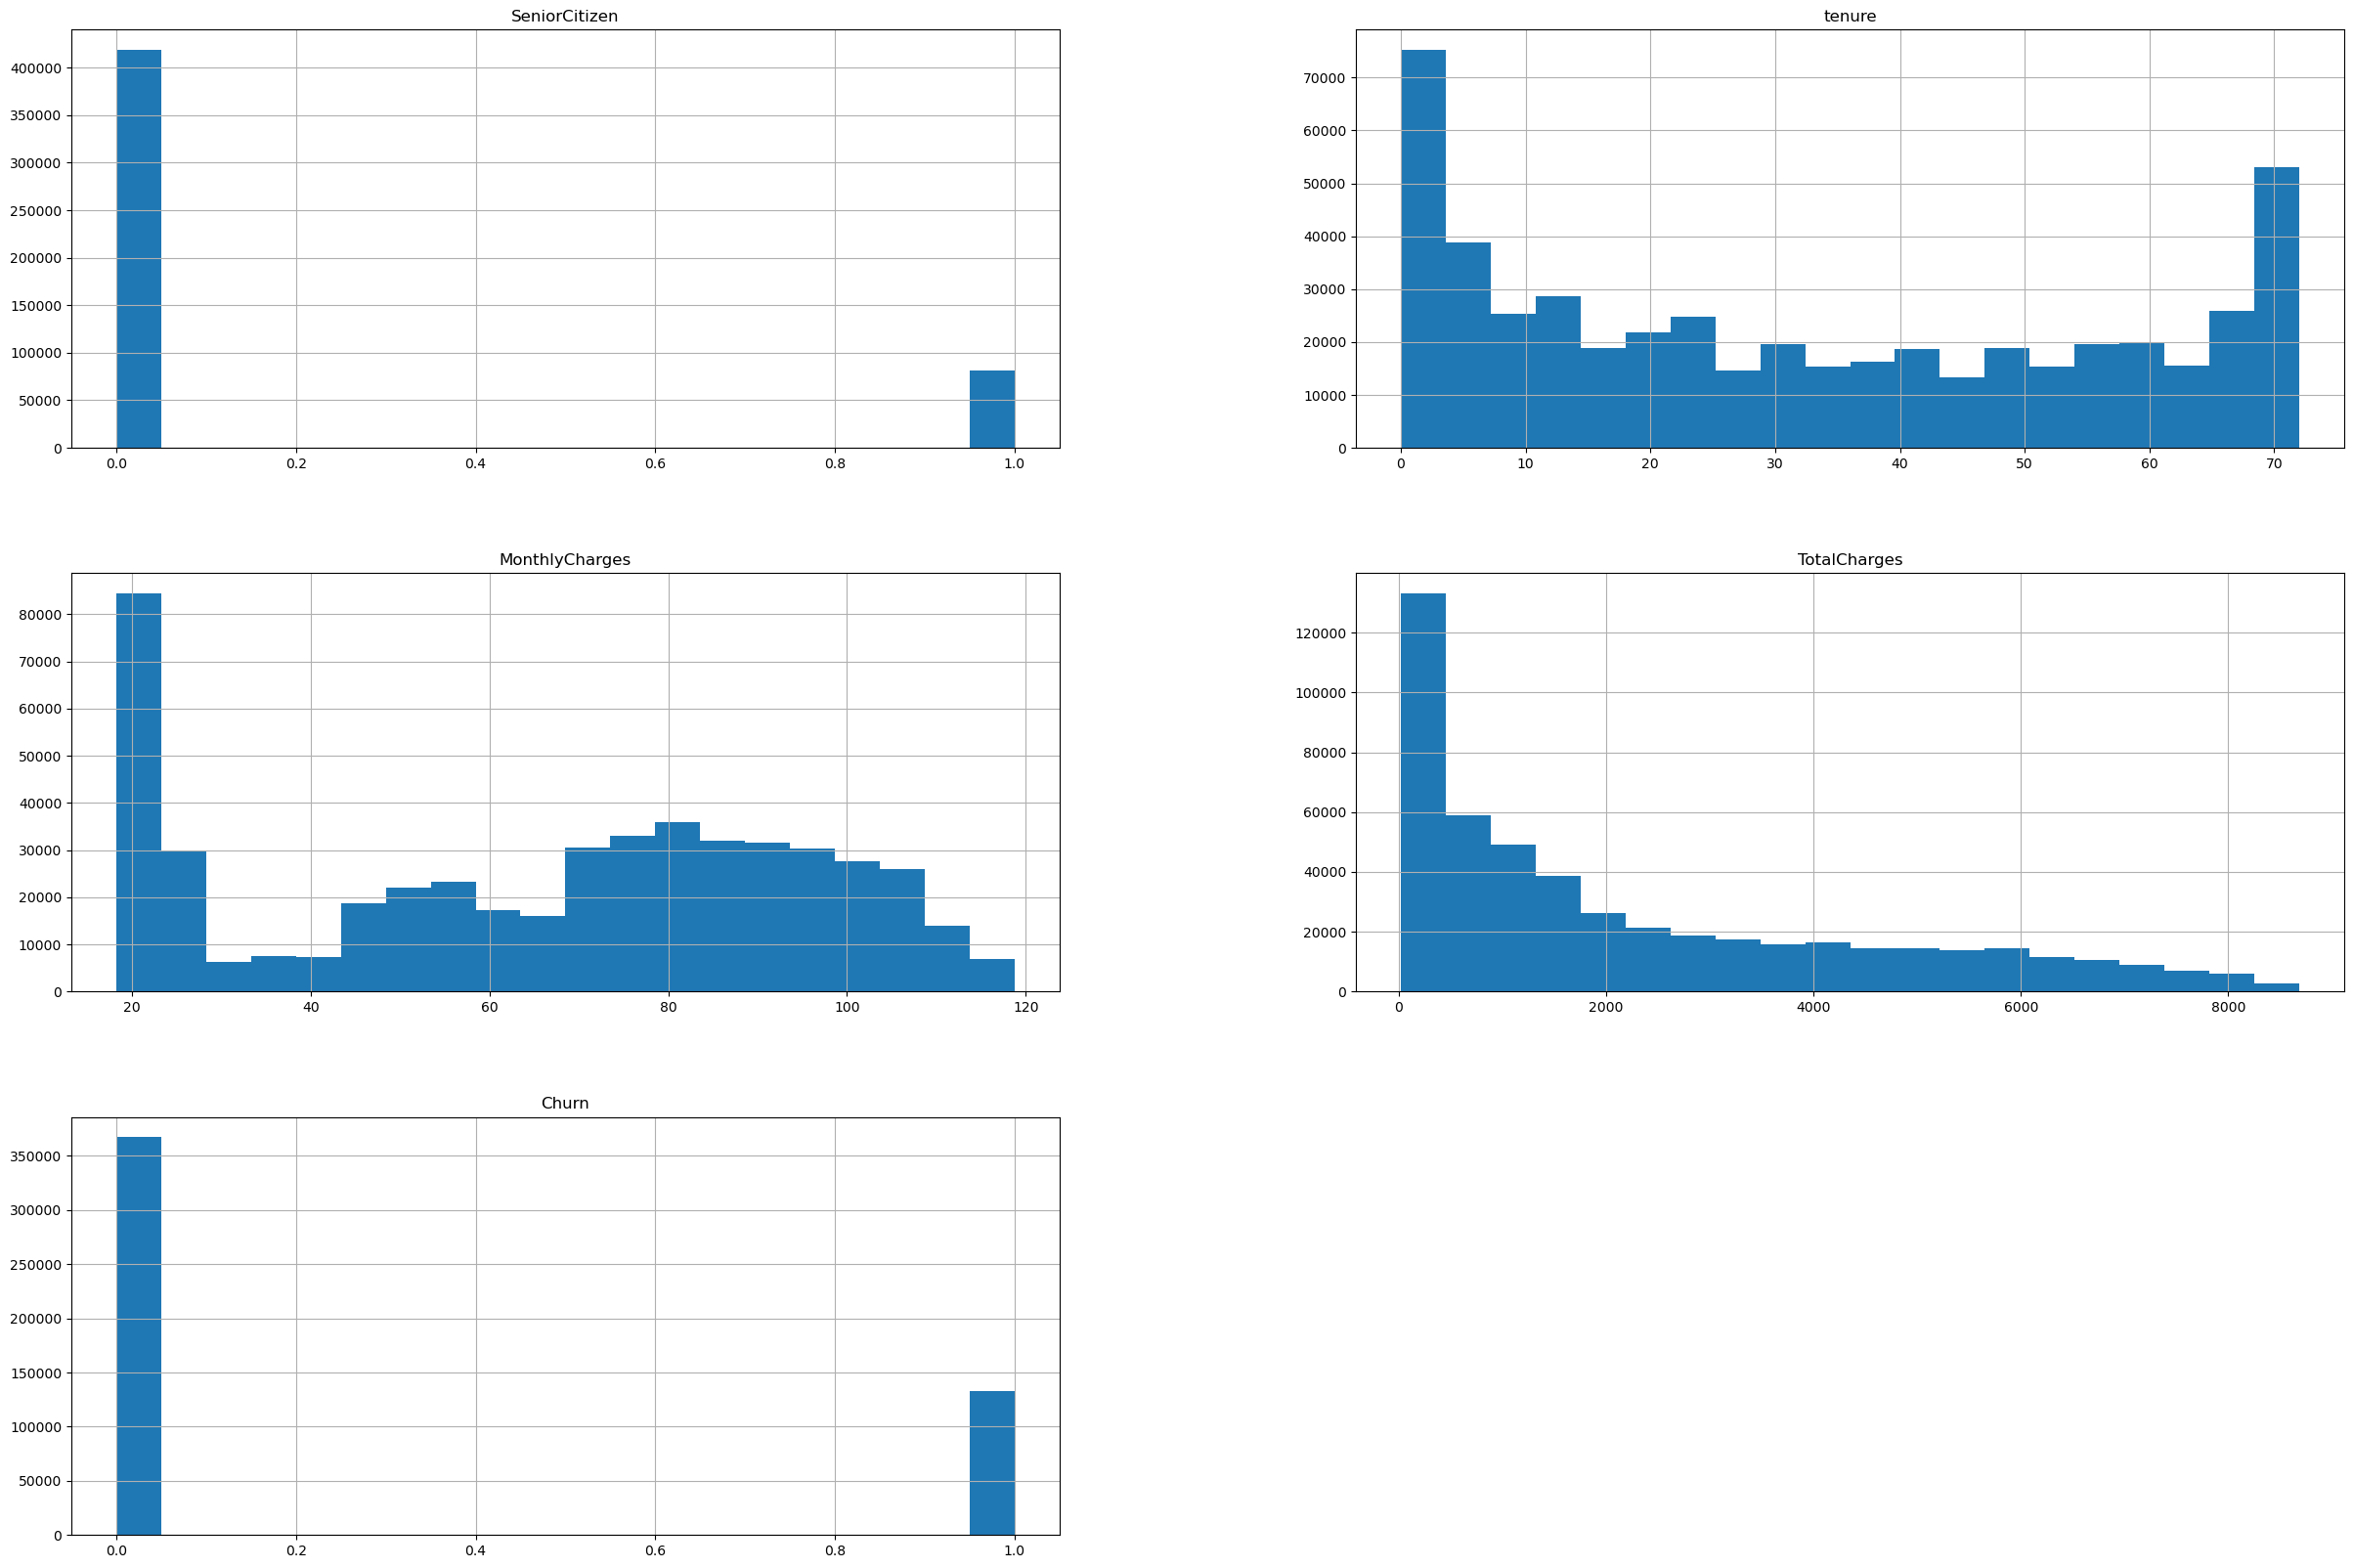

In [19]:
# To see the histogram chart: Histograms are a great way to explore columns with numerical data.
num_bins = 20
df.hist(bins=num_bins, figsize=(30,20))
plt.savefig("churn_histogram")
plt.show()

In [21]:
 def grab_col_names(dataframe, cat_th=10, car_th=20):  
    """
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
            df: Dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                threshold value for numeric but categorical variables
        car_th: int, optinal
                threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical but cardinal variable list

    Examples
    ------
        You just need to call the function and send the dataframe.)
        
        --> grab_col_names(df)

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: 
        cat_cols + num_cols + cat_but_car = number of variables

    """
def grab_col_names(dataframe, cat_th=10, car_th=20):
  
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

cat_cols
num_cols

Observations: 500000
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


['tenure', 'MonthlyCharges', 'TotalCharges']

####  Analyze the numerical and categorical variables

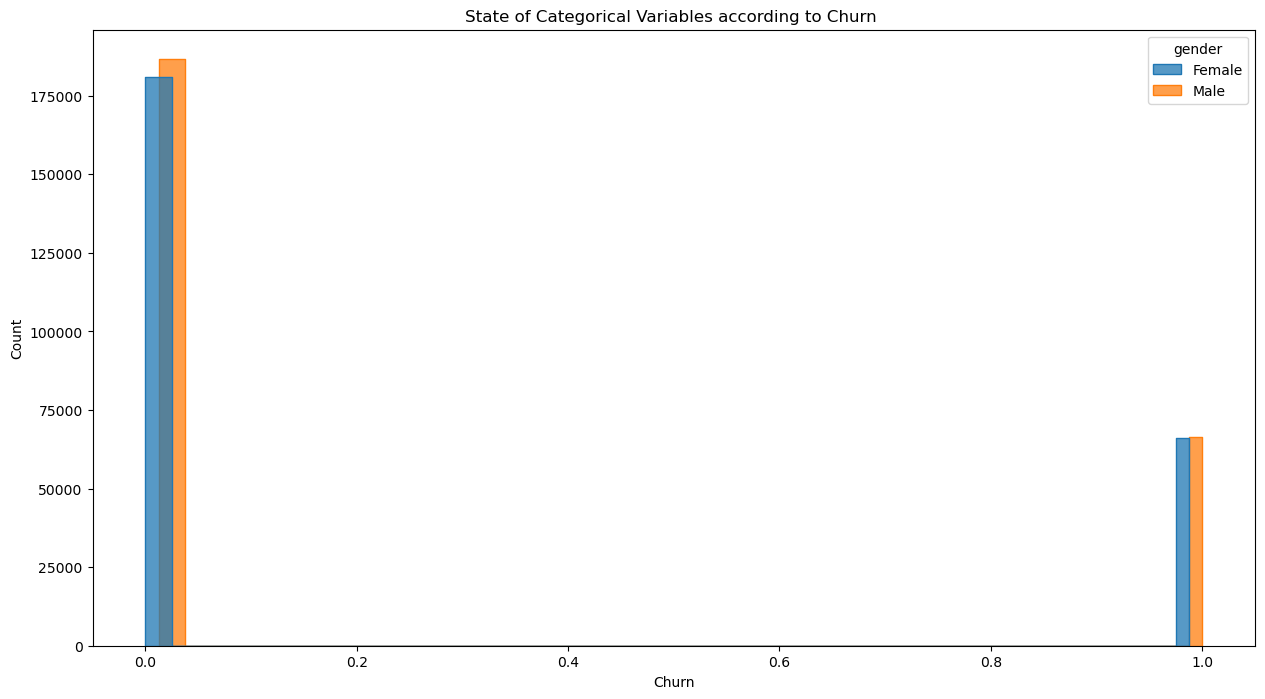

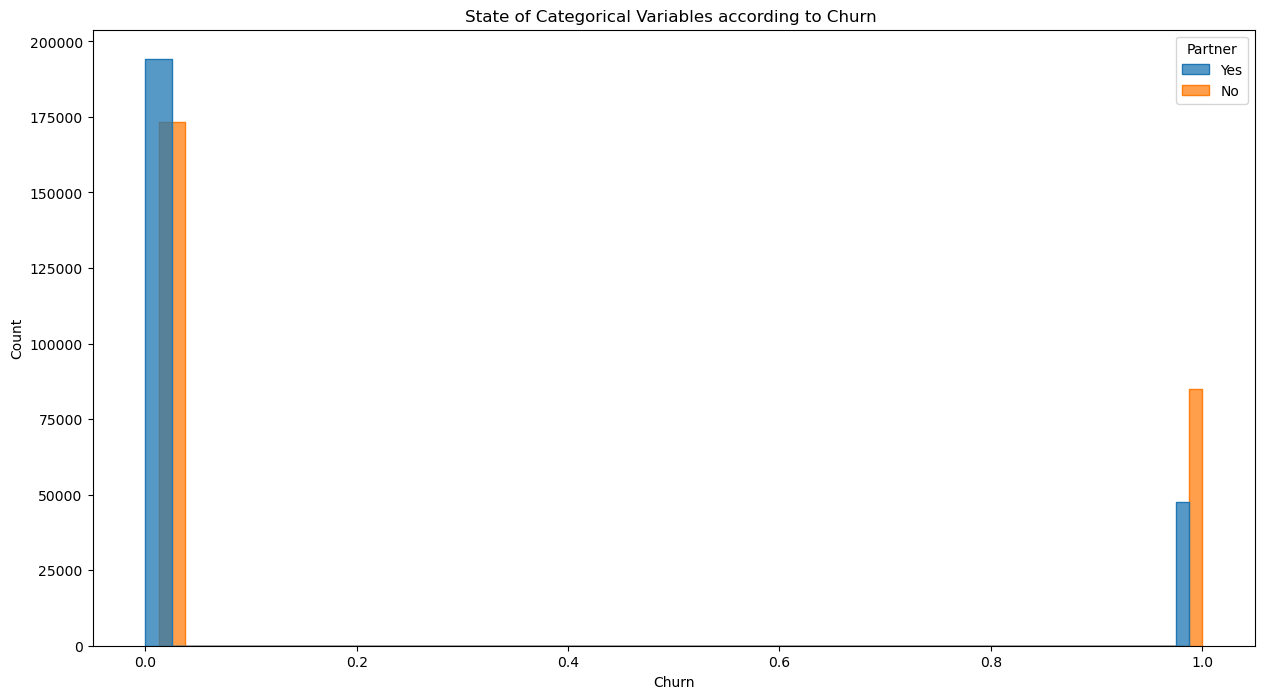

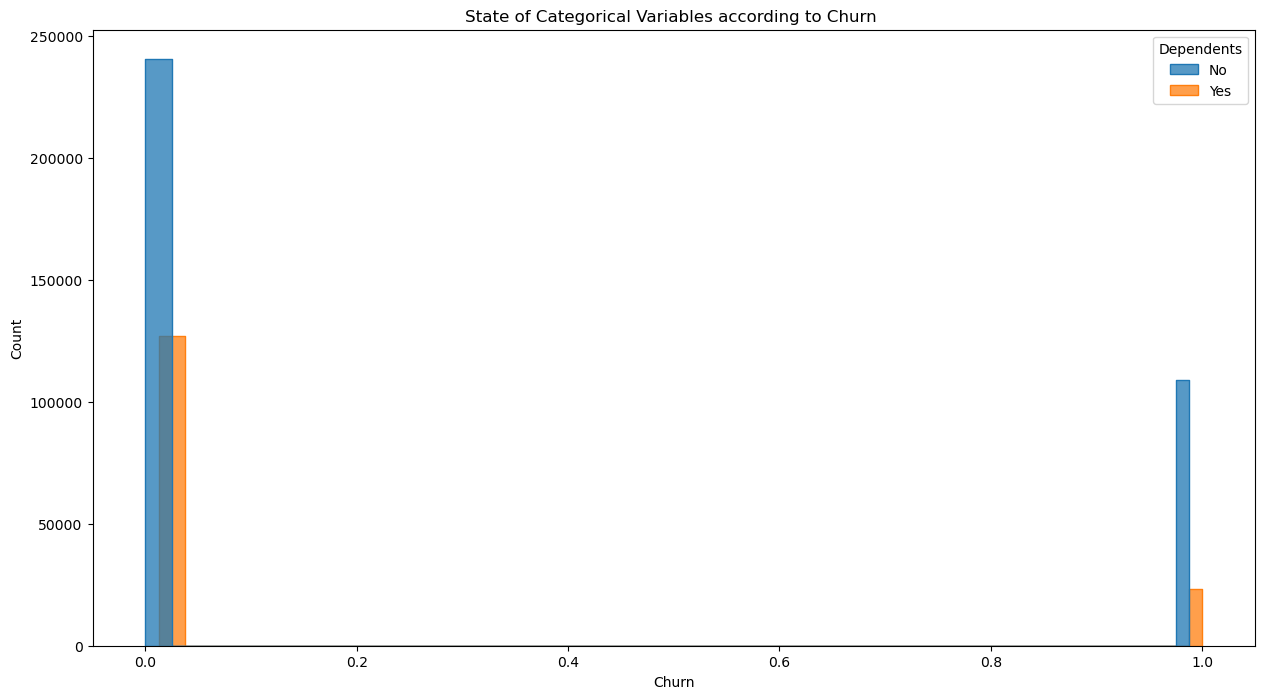

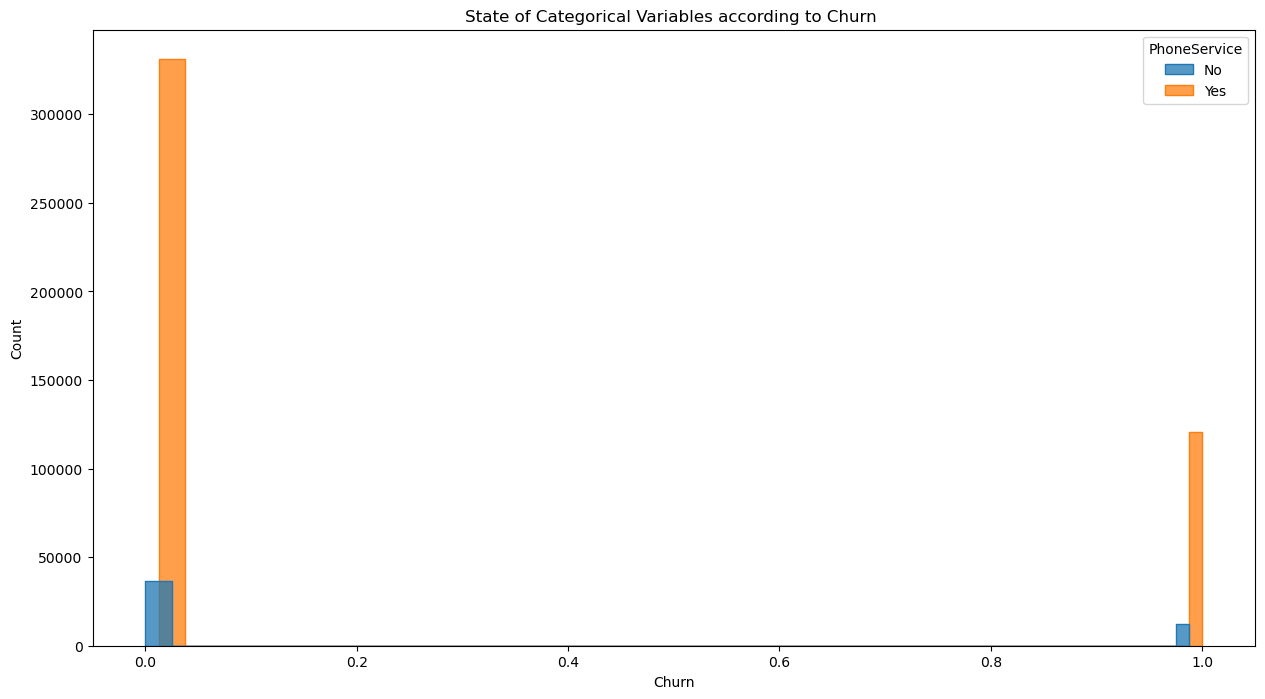

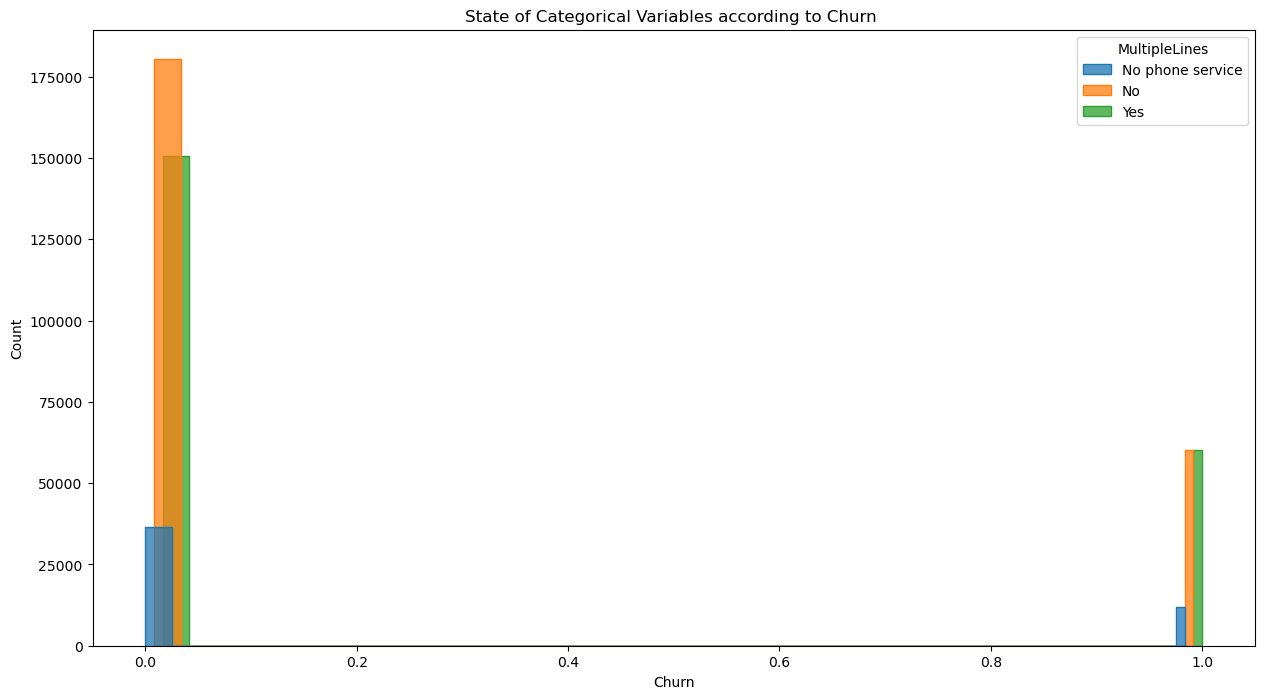

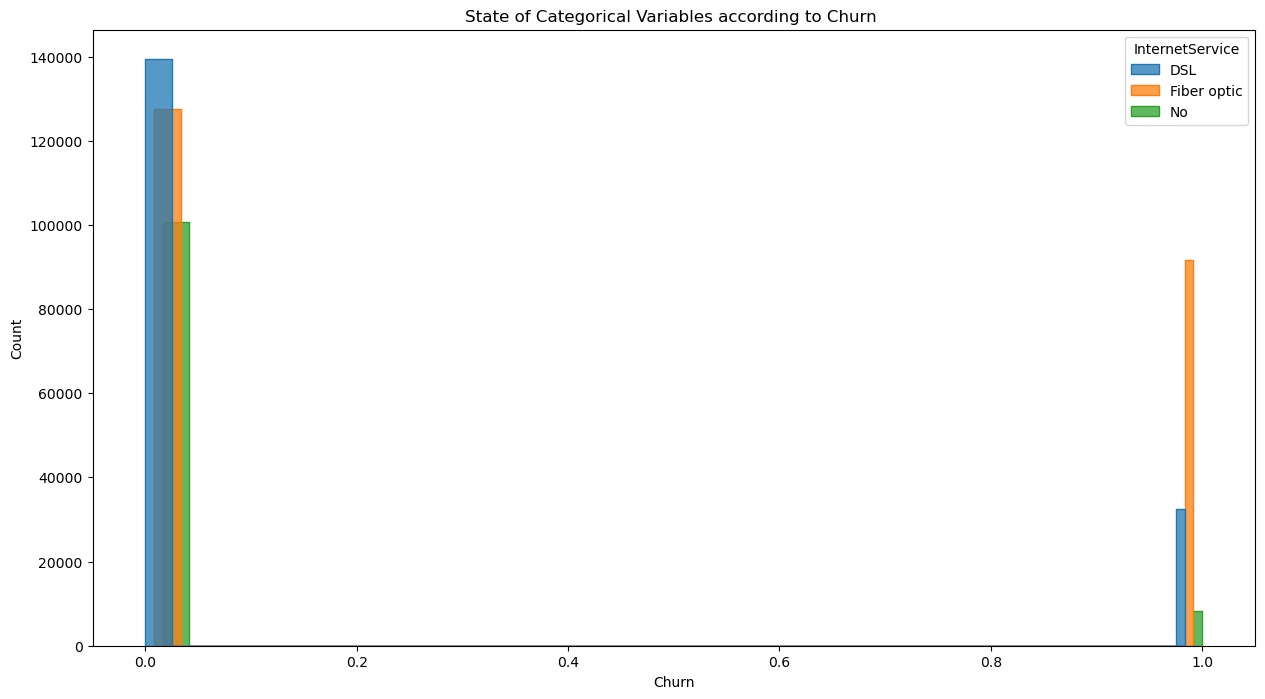

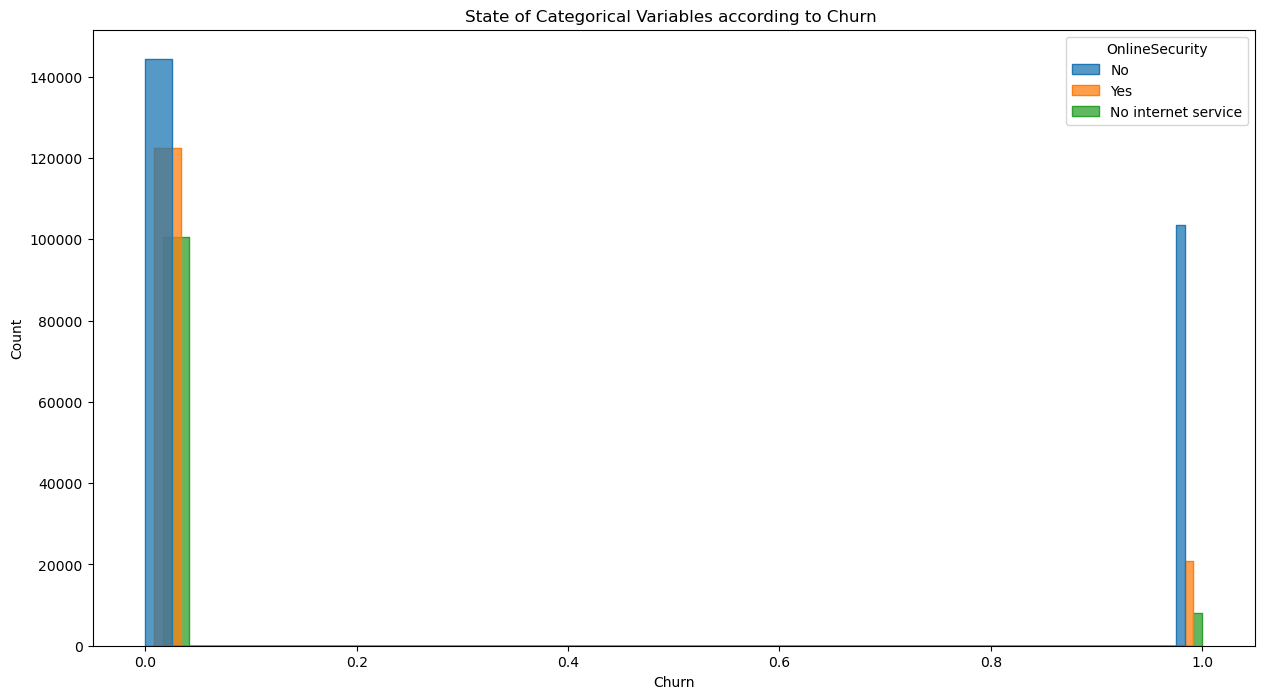

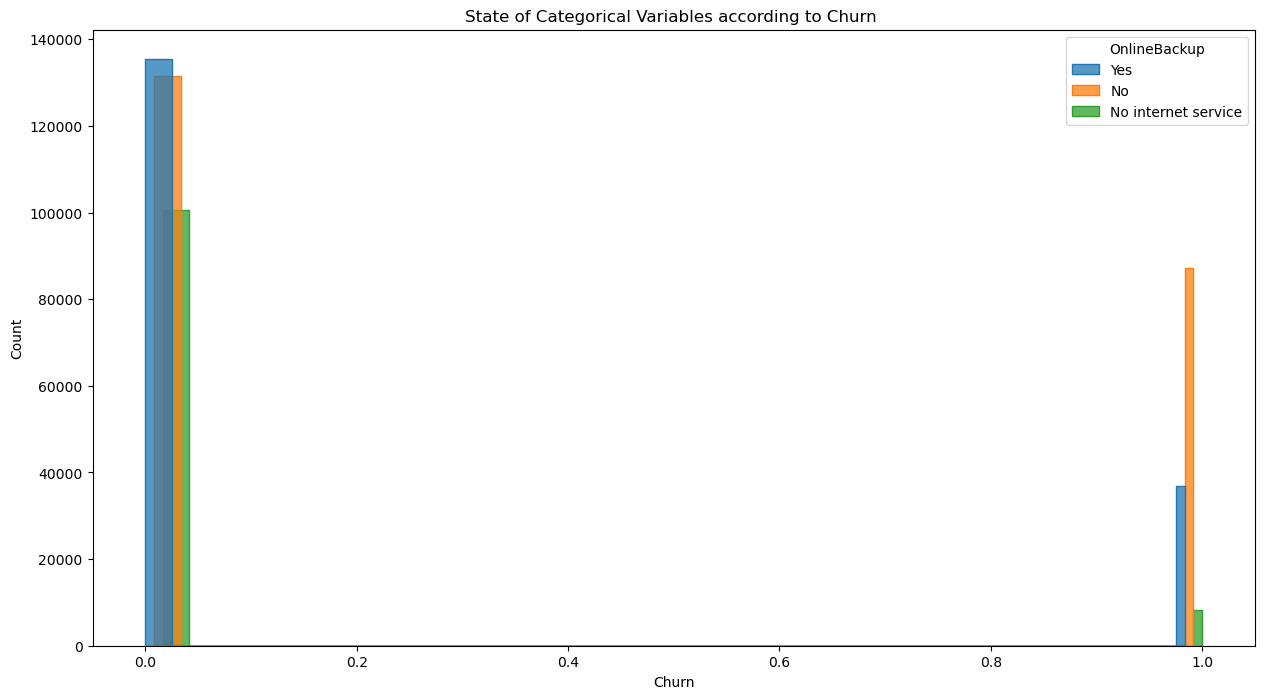

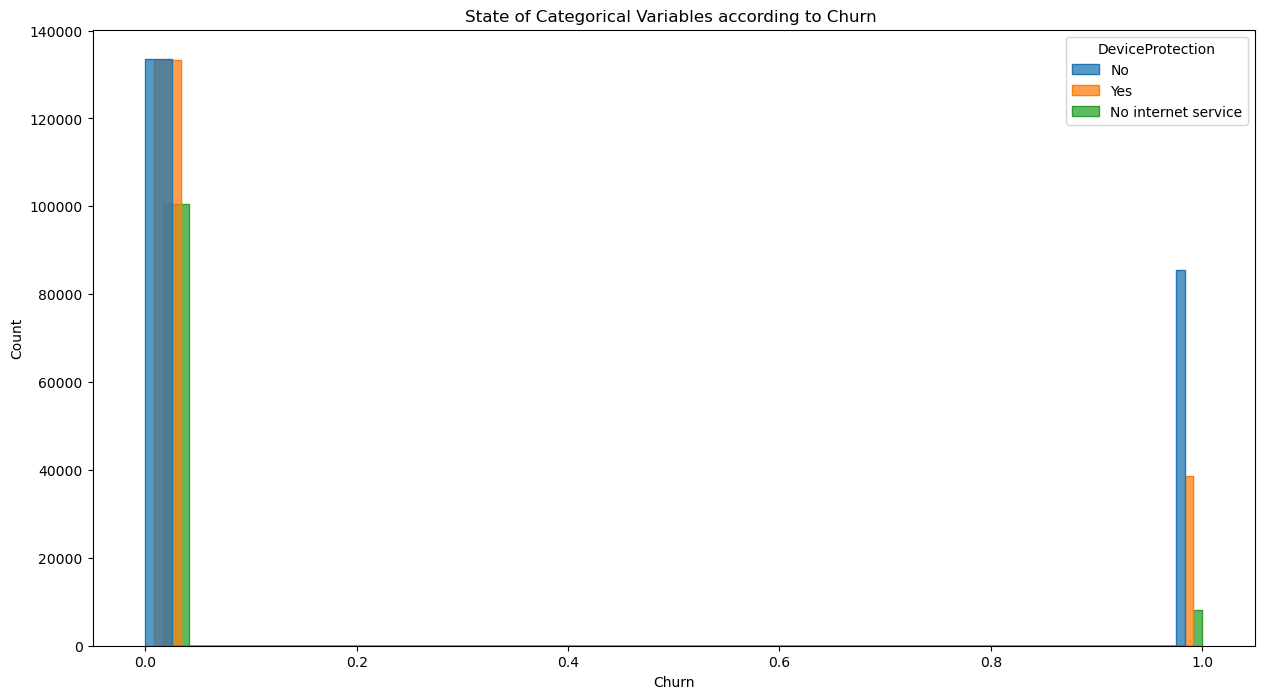

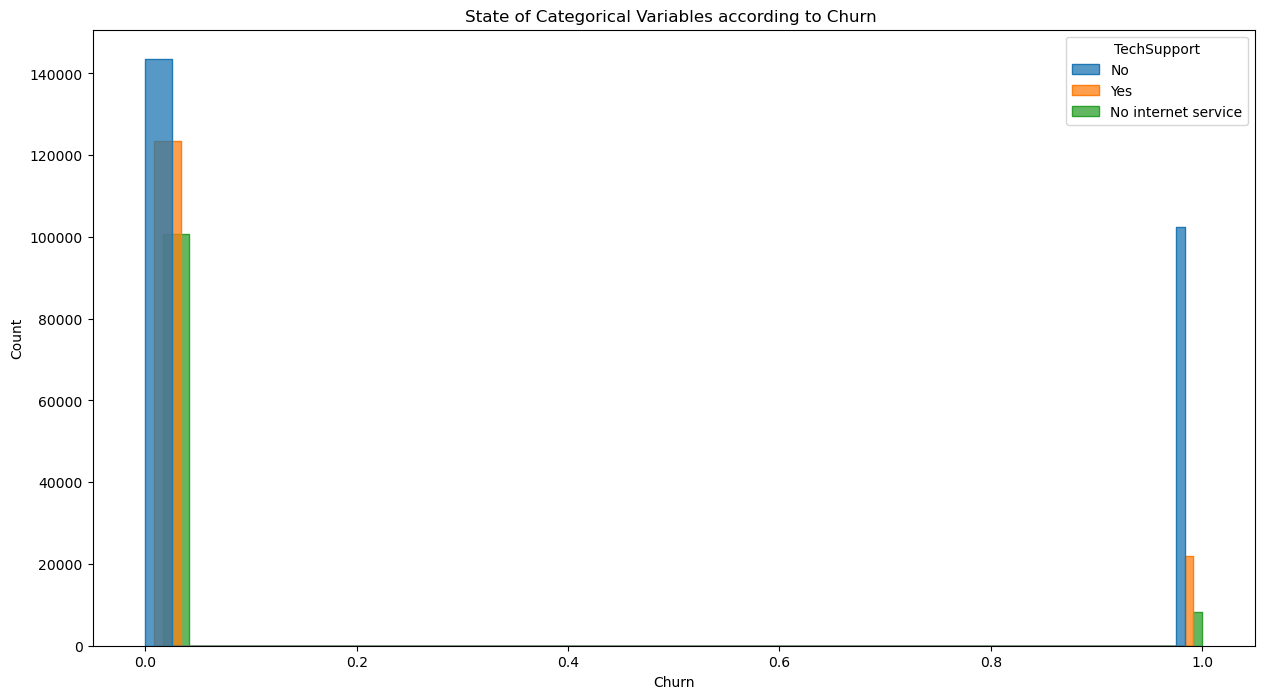

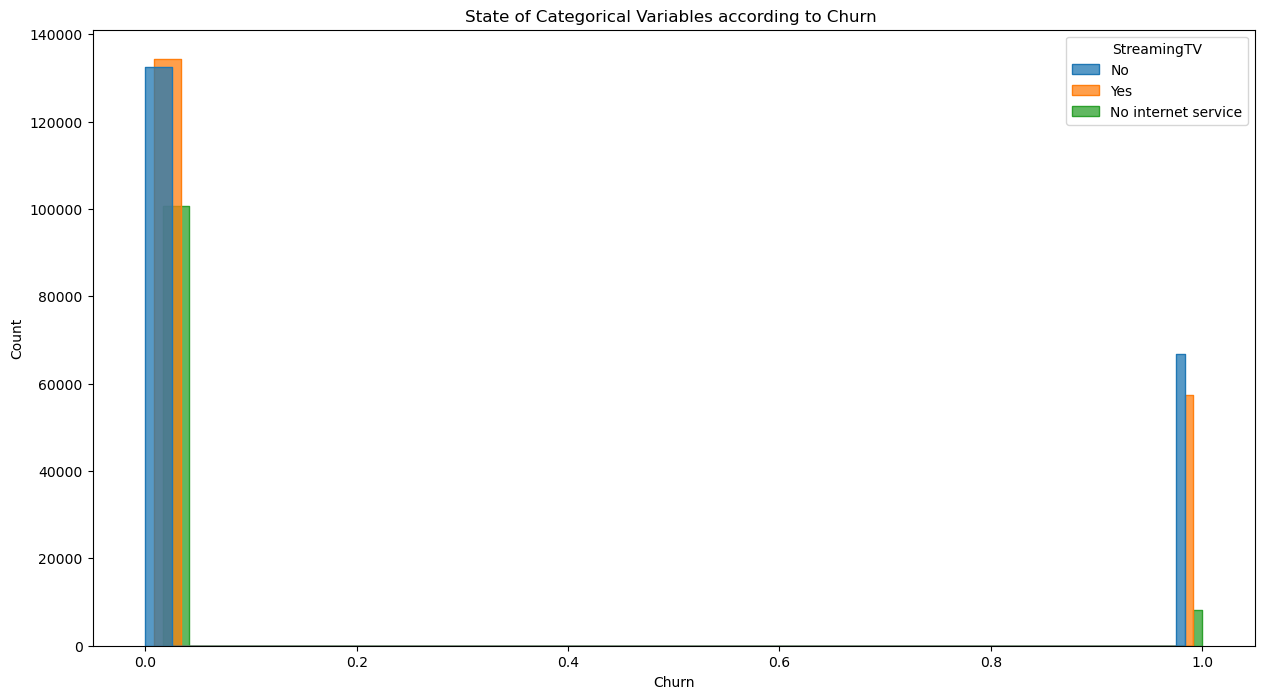

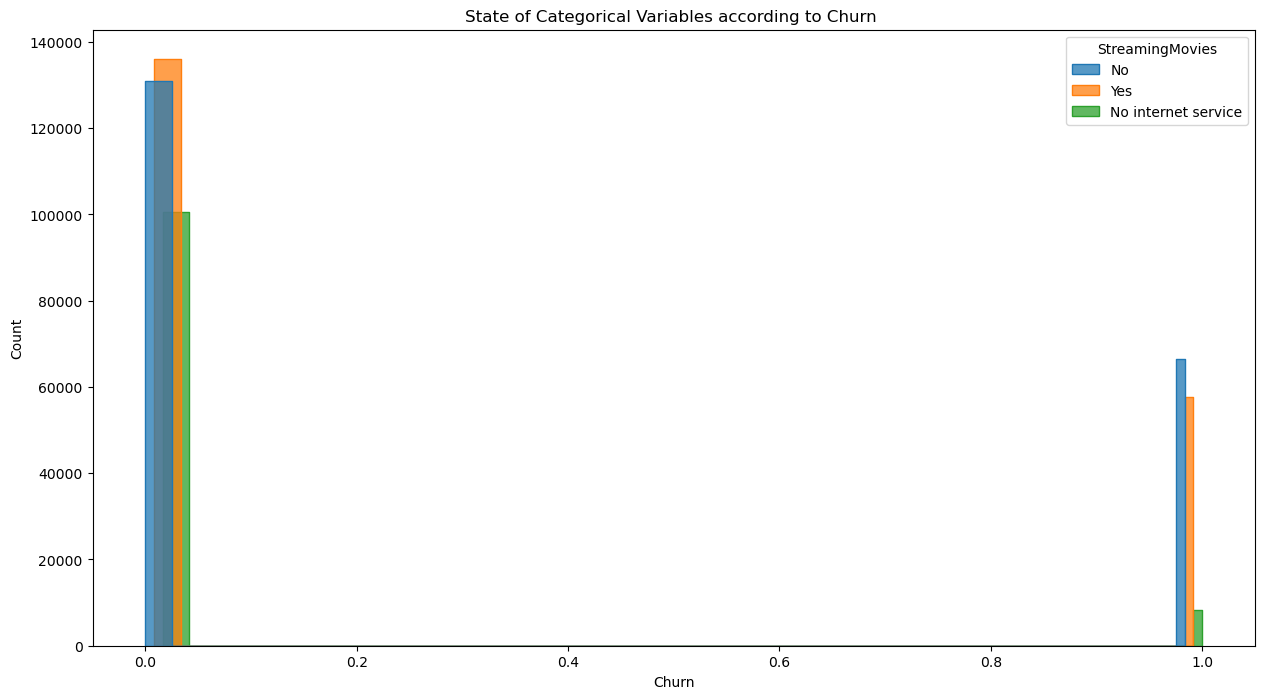

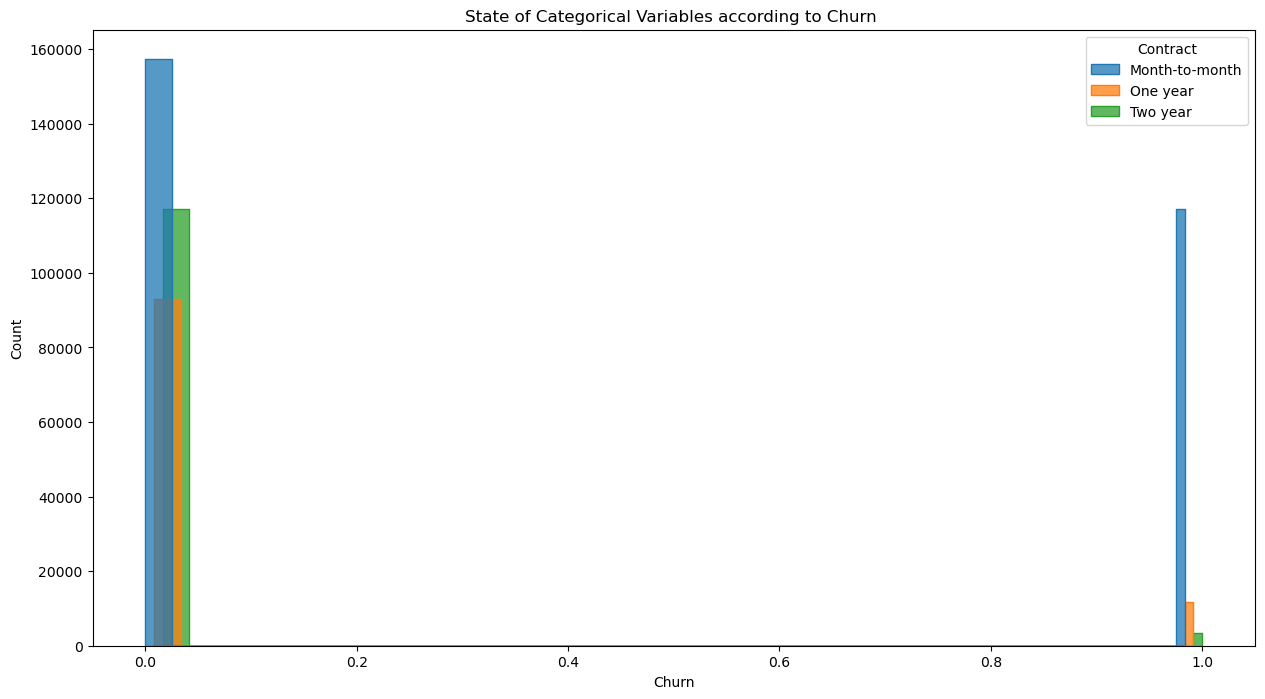

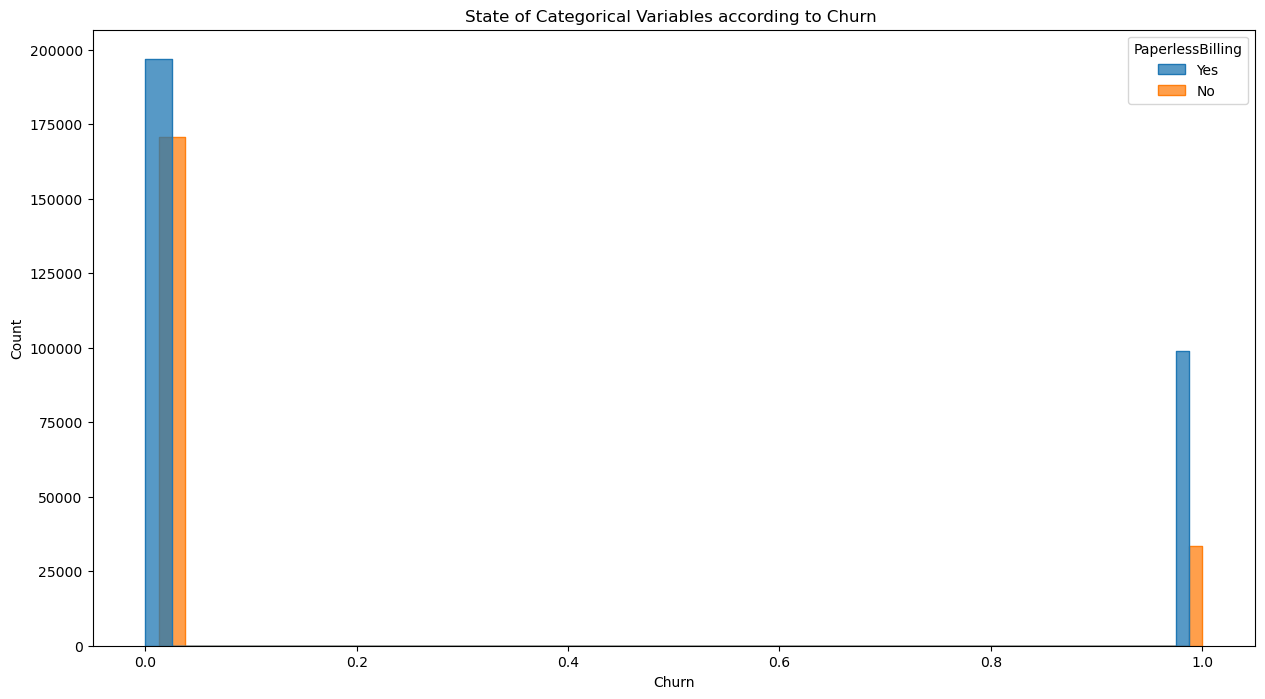

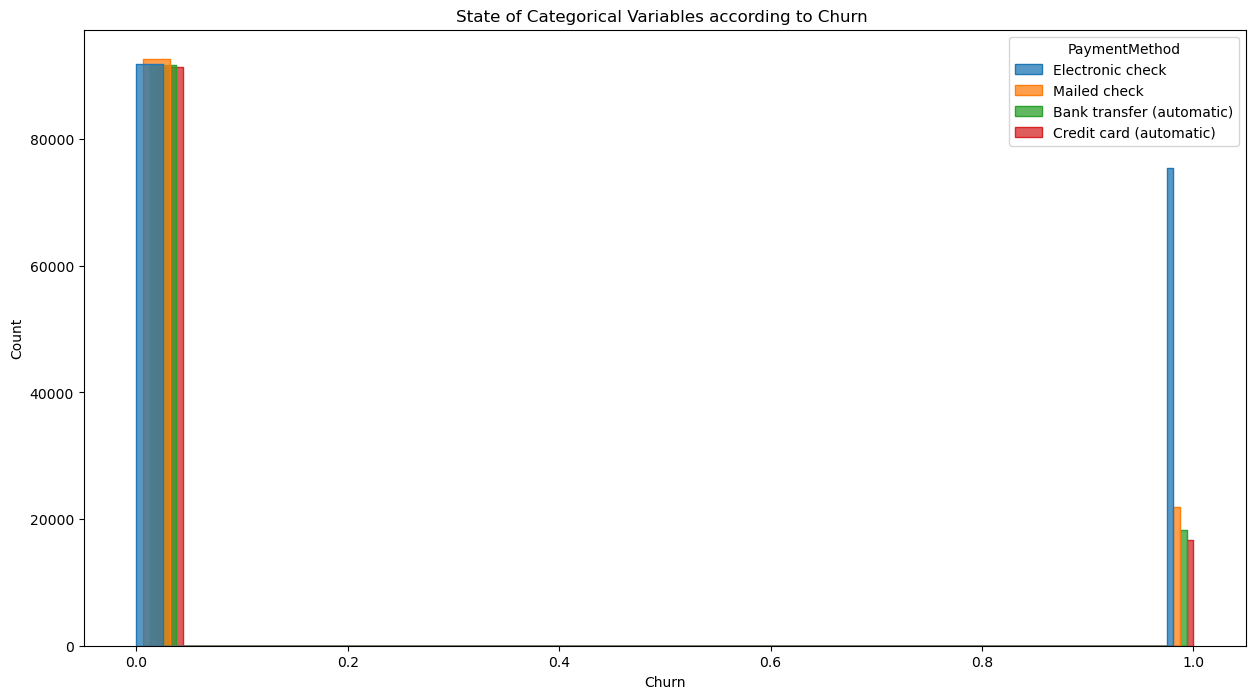

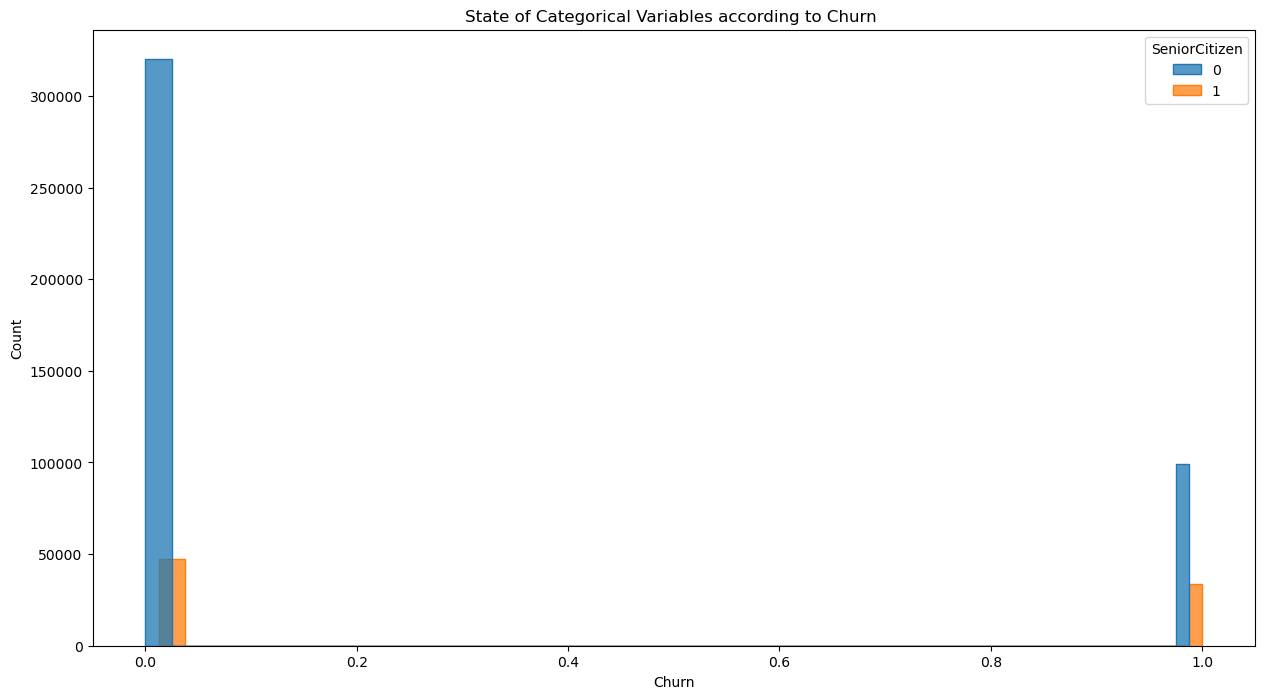

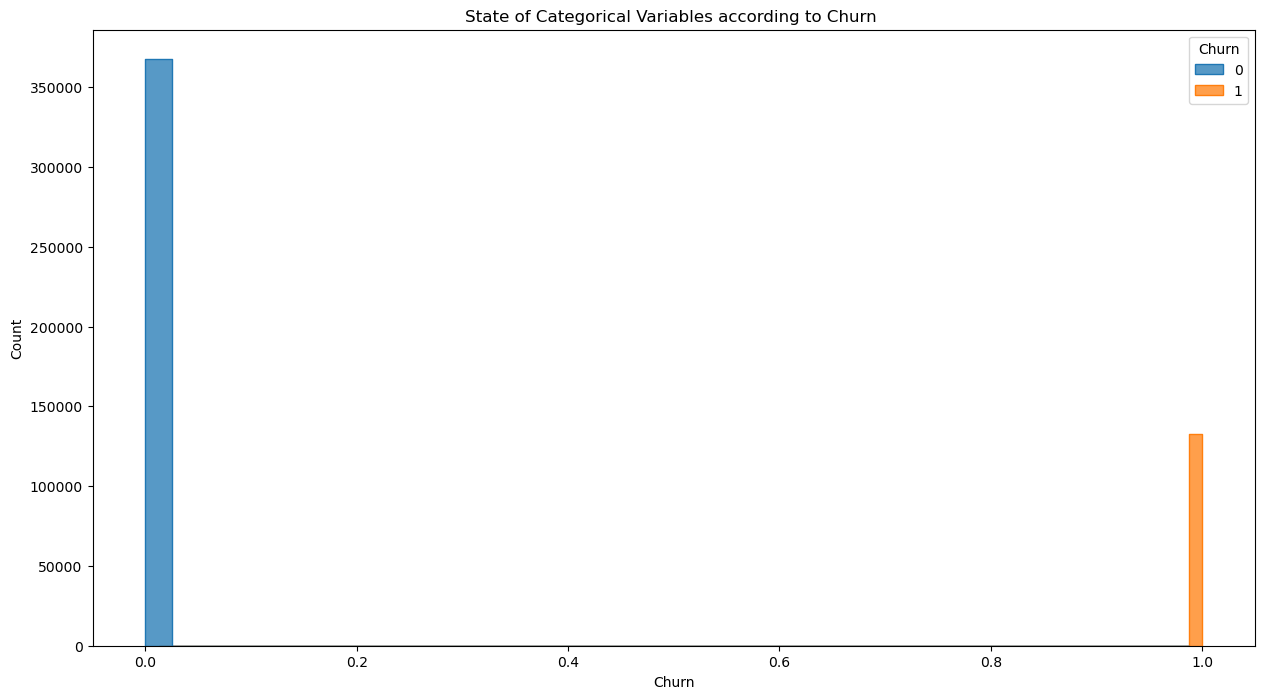

In [22]:
def target_vs_category_visual(dataframe, target, categorical_col):
    plt.figure(figsize=(15, 8))
    sns.histplot(x=target, hue=categorical_col, data=dataframe, element="step", multiple="dodge")
    plt.title("State of Categorical Variables according to Churn ")
    plt.show()


for col in cat_cols:
    target_vs_category_visual(df, "Churn", col)

In [23]:
# We continue the analysis by examining the relationship of the Churn variable with other variables.

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"CHURN_MEAN": dataframe.groupby(categorical_col)[target].mean()}))


for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

        CHURN_MEAN
gender            
Female       0.268
Male         0.262
         CHURN_MEAN
Partner            
No            0.329
Yes           0.197
            CHURN_MEAN
Dependents            
No               0.312
Yes              0.155
              CHURN_MEAN
PhoneService            
No                 0.249
Yes                0.267
                  CHURN_MEAN
MultipleLines               
No                     0.250
No phone service       0.249
Yes                    0.285
                 CHURN_MEAN
InternetService            
DSL                   0.189
Fiber optic           0.418
No                    0.075
                     CHURN_MEAN
OnlineSecurity                 
No                        0.418
No internet service       0.075
Yes                       0.145
                     CHURN_MEAN
OnlineBackup                   
No                        0.399
No internet service       0.075
Yes                       0.214
                     CHURN_MEAN
DeviceProtectio

#### Perform outlier observation analysis.

In [24]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


#### Perform a missing observation analysis.

In [25]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

              n_miss  ratio
TotalCharges     837  0.170


##### Perform correlation analysis.

In [26]:
corr_matrix = df[num_cols].corr()
corr_matrix

,tenure,MonthlyCharges,TotalCharges
tenure,1.000,0.248,0.826
MonthlyCharges,0.248,1.000,0.651
TotalCharges,0.826,0.651,1.000


In [27]:
df.corrwith(df["Churn"]).sort_values(ascending=False)

Churn             1.000
MonthlyCharges    0.192
SeniorCitizen     0.149
TotalCharges     -0.201
tenure           -0.354
dtype: float64

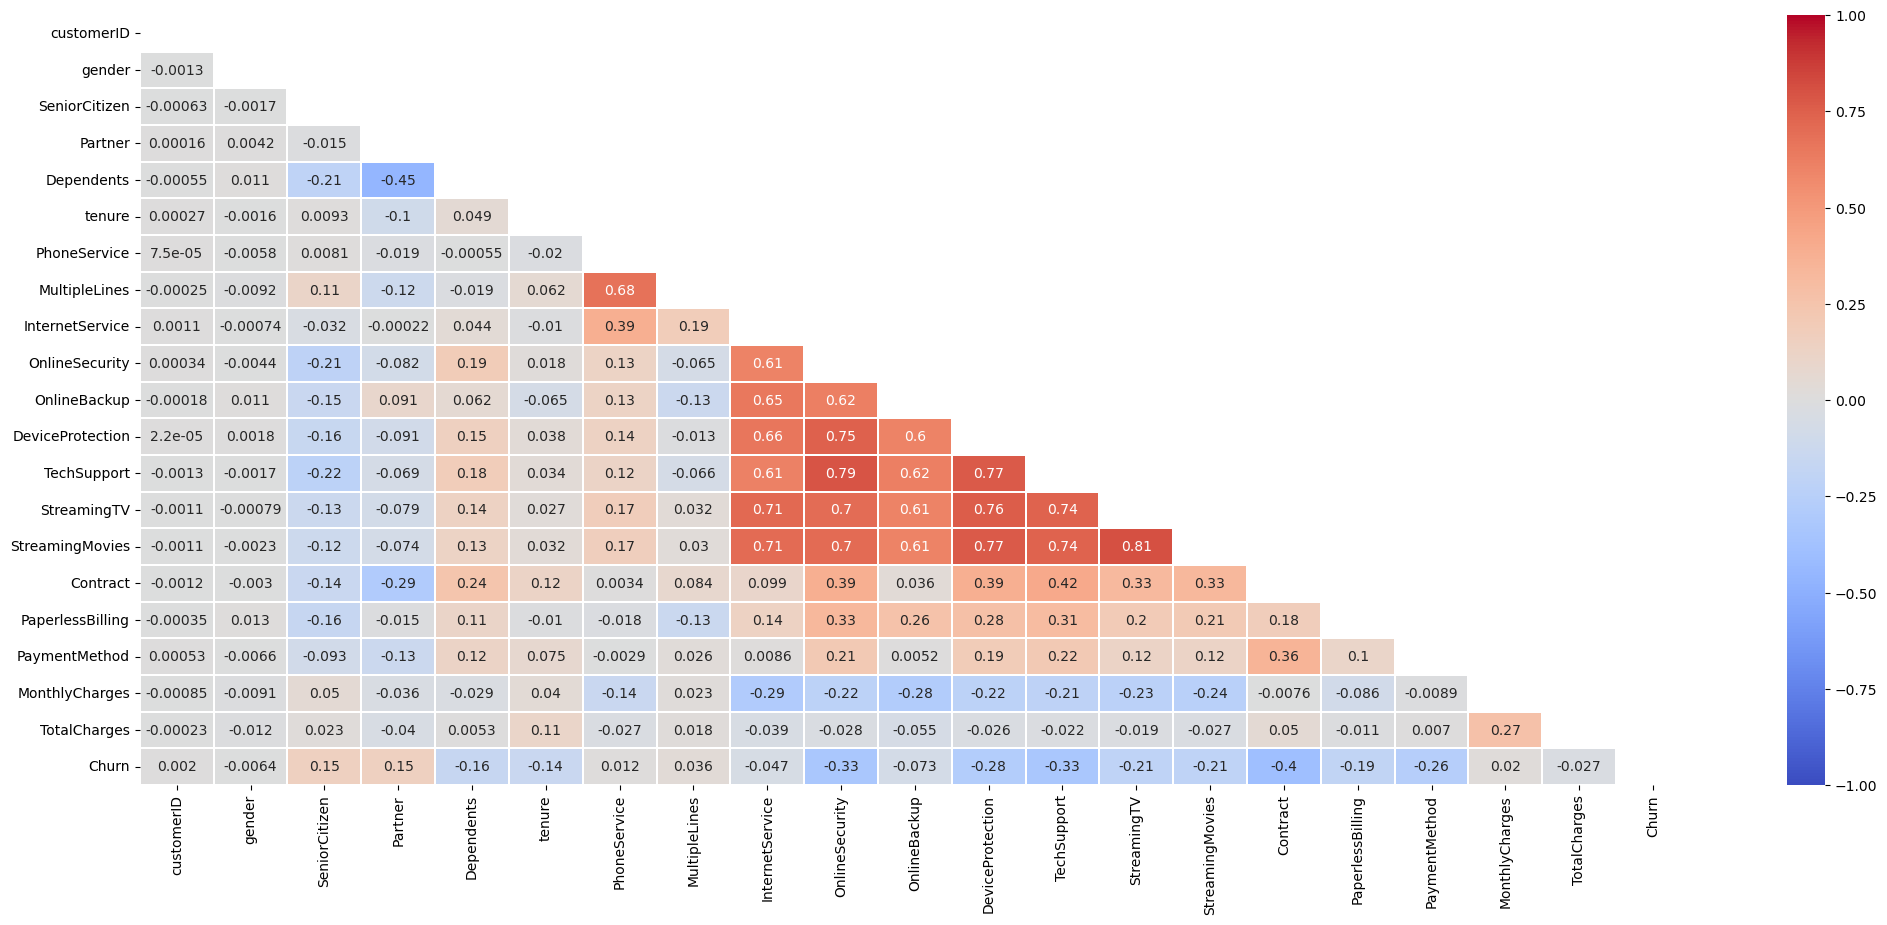

In [28]:
# Correlation between all variables
plt.figure(5, figsize=(25, 10))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

findfont: Font family 'charter' not found.
findfont: Font family 'charter' not found.
findfont: Font family 'charter' not found.
findfont: Font family 'charter' not found.
findfont: Font family 'charter' not found.
findfont: Font family 'charter' not found.
findfont: Font family 'charter' not found.
findfont: Font family 'charter' not found.


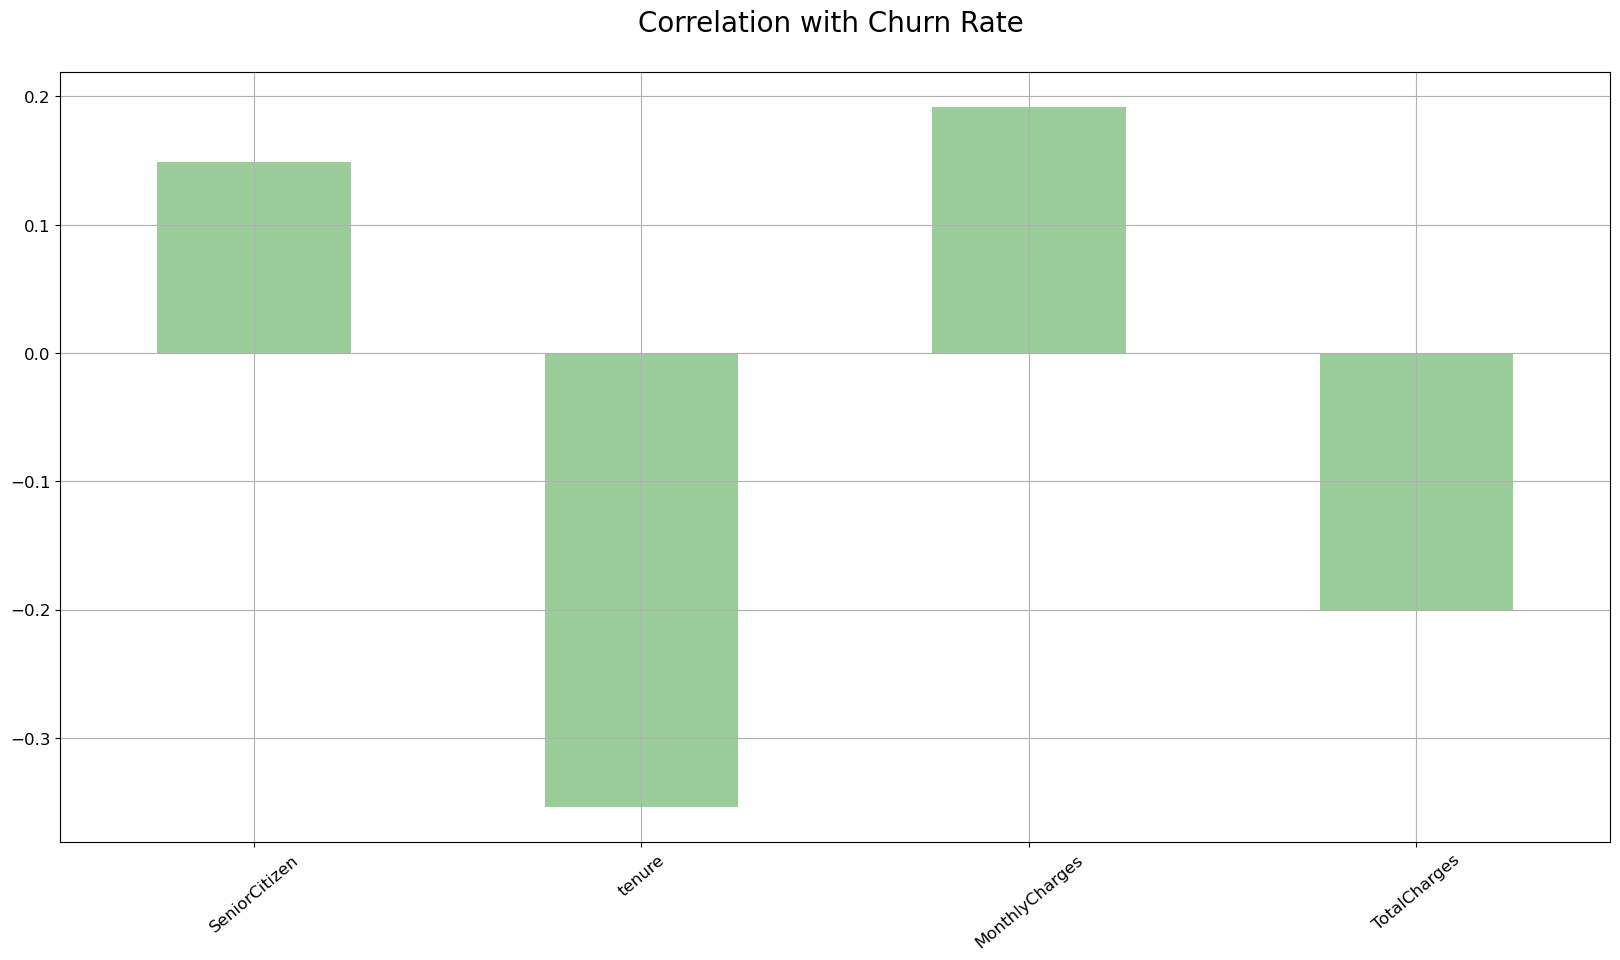

In [29]:
# Correlation between churn and selected boolean and numeric variables
plt.figure()
ds_corr = df[['SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling',
        'MonthlyCharges', 'TotalCharges']]

correlations = ds_corr.corrwith(df.Churn)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (20, 10),
        fontsize = 12,
        color = '#9BCD9B',
        rot = 40, grid = True)

plt.title('Correlation with Churn Rate \n', horizontalalignment="center", fontstyle = "normal", fontsize = "20", fontfamily = "charter")

##### Take necessary actions for missing and contradictory observations.

In [30]:
na_cols = missing_values_table(df, True)
df.dropna(inplace=True)

              n_miss  ratio
TotalCharges     837  0.170


In [31]:
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

##### Label Encode Binary data: Independent variables for machine learning algorithms can typically only have numerical values. Label encoding is used for all categorical variables with only two unique values.

In [32]:
le = LabelEncoder()

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    df = label_encoder(df, col)

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 30 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499163 entries, 0 to 499999
Data columns (total 32 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   customerID                             499163 non-null  object 
 1   gender                                 499163 non-null  int32  
 2   SeniorCitizen                          499163 non-null  int64  
 3   Partner                                499163 non-null  int32  
 4   Dependents                             499163 non-null  int32  
 5   tenure                                 499163 non-null  int64  
 6   PhoneService                           499163 non-null  int32  
 7   PaperlessBilling                       499163 non-null  int32  
 8   MonthlyCharges                         499163 non-null  float64
 9   TotalCharges                           499163 non-null  float64
 10  Churn                                  499163 non-null  

In [34]:
# Standardize for numeric variables.

num_cols = [col for col in num_cols if col not in "customerID"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df[num_cols].head()

,tenure,MonthlyCharges,TotalCharges
0,-1.281,-1.159,-0.993
1,0.064,-0.259,-0.173
2,-1.240,-0.362,-0.959
3,0.512,-0.746,-0.195
4,-1.240,0.198,-0.940


In [35]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,-1.281,0,1,-1.159,-0.993,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,0.064,1,0,-0.259,-0.173,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,3668-QPYBK,1,0,0,0,-1.240,1,1,-0.362,-0.959,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,0.512,0,0,-0.746,-0.195,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,-1.240,1,1,0.198,-0.940,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Build a model

In [36]:
y = df['Churn']
X = df.drop(["customerID", "Churn"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.9975024874957429

### Conclusion